In [1]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import time

from torch.utils.data import DataLoader
from tqdm import tqdm
from torchsummary import summary
from PIL import Image

In [2]:
dataset = '/home/leonardo/Documents/mod_comp_02/Learning_transference_Img_biomed_classification/Brain_Tumor_MRI_dataset/'

Training_directory = os.path.join(dataset, 'Training')
validate_directory = os.path.join(dataset, 'validate')

print(f'Training_directory{Training_directory}')
print(f'validate directory{validate_directory}')


Training_directory/home/leonardo/Documents/mod_comp_02/Learning_transference_Img_biomed_classification/Brain_Tumor_MRI_dataset/Training
validate directory/home/leonardo/Documents/mod_comp_02/Learning_transference_Img_biomed_classification/Brain_Tumor_MRI_dataset/validate


In [3]:
# Batch size
bs = 32

# Number of classes
num_classes = len(os.listdir(Training_directory))  #10#2#257
print(num_classes)

4


In [4]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [5]:
# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=Training_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=validate_directory, transform=image_transforms['valid'])
}


In [6]:

idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


In [7]:
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)

In [8]:
train_data_size, valid_data_loader

(5712, <torch.utils.data.dataloader.DataLoader at 0x7fd145887e50>)

In [9]:
googlenet = models.googlenet(pretrained=True)
googlenet

/home/leonardo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/leonardo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [10]:
for param in googlenet.parameters():
    param.requires_grad = False

In [11]:
# Modify the last layer of the classifier by replacing it with another fully connected layer
num_classes = 4096 # Replace 10 with the desired number of output classes
in_features = googlenet.fc.in_features
out_features = num_classes
googlenet.fc = nn.Linear(in_features, out_features)

# Add a LogSoftmax layer to normalize the output of the model
googlenet.softmax = nn.LogSoftmax(dim=1)

# Print the modified GoogleNet model architecture
print(googlenet)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [12]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(googlenet.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [13]:
def train_and_validate(model, loss_criterion, optimizer, epochs=6):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [14]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(3, dim=1)
        for i in range(3):
            print("Prediction", i+1, ":", idx_to_class[topclass.numpy()[0][i]], ", Score: ", topk.numpy()[0][i])

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 15

trained_model, history = train_and_validate(googlenet, loss_func, optimizer, num_epochs)
torch.save(history, dataset + '_history_googleNet_img_classficiation.pt')


Epoch: 1/15
Epoch : 001, Training: Loss: -30.5476, Accuracy: 27.6436%, 
		Validation : Loss : -60.2346, Accuracy: 22.8833%, Time: 388.1413s
Epoch: 2/15
Epoch : 002, Training: Loss: -92.1155, Accuracy: 33.9811%, 
		Validation : Loss : -119.5719, Accuracy: 45.4615%, Time: 355.5252s
Epoch: 3/15
Epoch : 003, Training: Loss: -153.6953, Accuracy: 37.7626%, 
		Validation : Loss : -180.5268, Accuracy: 32.5706%, Time: 283.0483s
Epoch: 4/15
Epoch : 004, Training: Loss: -215.3347, Accuracy: 29.1842%, 
		Validation : Loss : -240.1551, Accuracy: 31.6552%, Time: 283.6213s
Epoch: 5/15
Epoch : 005, Training: Loss: -276.7709, Accuracy: 30.6898%, 
		Validation : Loss : -297.3775, Accuracy: 31.1976%, Time: 284.1107s
Epoch: 6/15
Epoch : 006, Training: Loss: -338.5759, Accuracy: 35.1190%, 
		Validation : Loss : -357.9334, Accuracy: 39.2830%, Time: 282.7904s
Epoch: 7/15
Epoch : 007, Training: Loss: -400.2945, Accuracy: 43.1197%, 
		Validation : Loss : -416.7423, Accuracy: 39.9695%, Time: 8162.0482s
Epoch: 8

In [16]:
history = np.array(history)


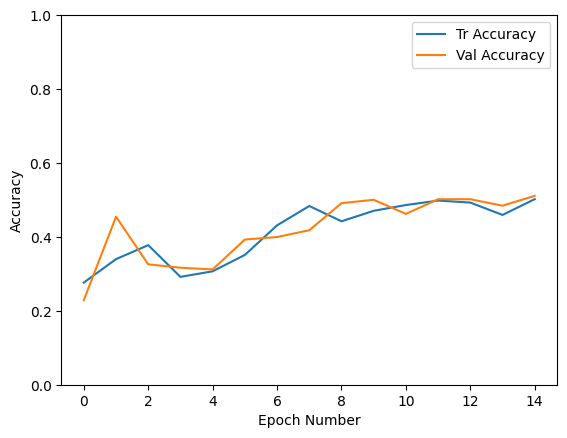

In [17]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

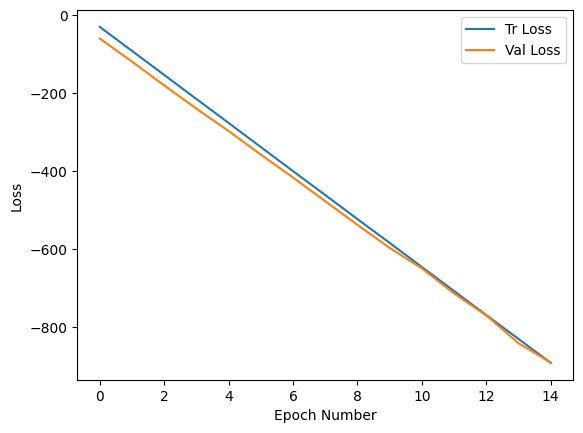

In [18]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.savefig(dataset+'_loss_curve.png')
plt.show()

realizamos las predicciones

Prediction 1 : glioma , Score:  inf
Prediction 2 : meningioma , Score:  inf
Prediction 3 : notumor , Score:  inf


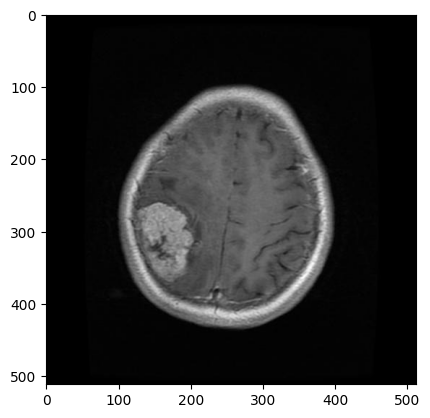

In [19]:
predict(trained_model, '/home/leonardo/Documents/mod_comp_02/Learning_transference_Img_biomed_classification/Brain_Tumor_MRI_dataset/Testing/meningioma_3.jpg')


Prediction 1 : glioma , Score:  inf
Prediction 2 : meningioma , Score:  inf
Prediction 3 : notumor , Score:  inf


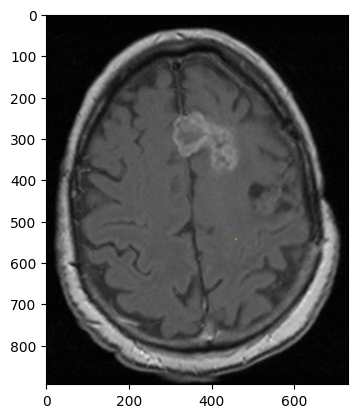

In [20]:
predict(trained_model, '/home/leonardo/Documents/mod_comp_02/Learning_transference_Img_biomed_classification/Brain_Tumor_MRI_dataset/Testing/glioma.jpg')

# interesante que alguna prediccion fallara, sera error nuestro?